# 0. Setup

In [26]:
import pathlib
import os
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math

from sklearn.model_selection import train_test_split

In [2]:
# Load preprocessed loan data
def load_loan_data():
    ROOT_PATH = pathlib.Path().resolve().parent
    raw_data_path = os.path.join(ROOT_PATH, 'raw_data', 'Loan_Default.csv')
    print(f"🔍 Checking for file at path: {raw_data_path}")

    if os.path.exists(raw_data_path):
        data = pd.read_csv(raw_data_path)
        print("✅ Data loaded successfully")
        return data
    else:
        raise FileNotFoundError(f"The file {raw_data_path} does not exist. Please check the path.")

In [3]:
# Load data
data = load_loan_data()

data.tail()

🔍 Checking for file at path: /Users/giliamo/code/YannAll/automated_loan_review_project/raw_data/Loan_Default.csv
✅ Data loaded successfully


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0
148669,173559,2019,cf,Female,nopre,type1,p3,l1,nopc,nob/c,...,CIB,830,CIB,45-54,not_inst,72.849462,North,direct,0,44.0


In [4]:
#Create a backup (to use the original data for the preprocessing)
data_backup = data.copy()

# 1. Explore Suspicious Variables

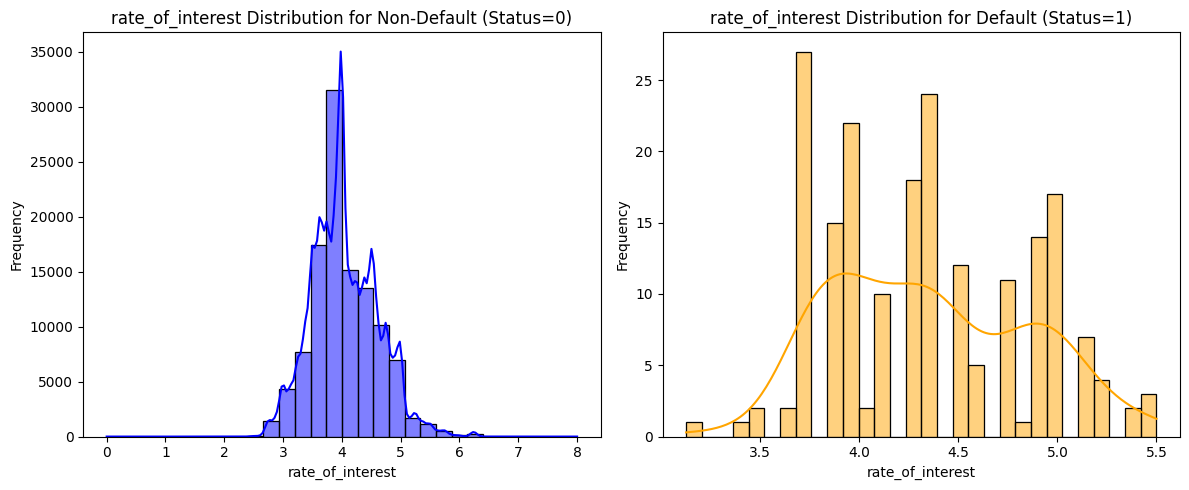

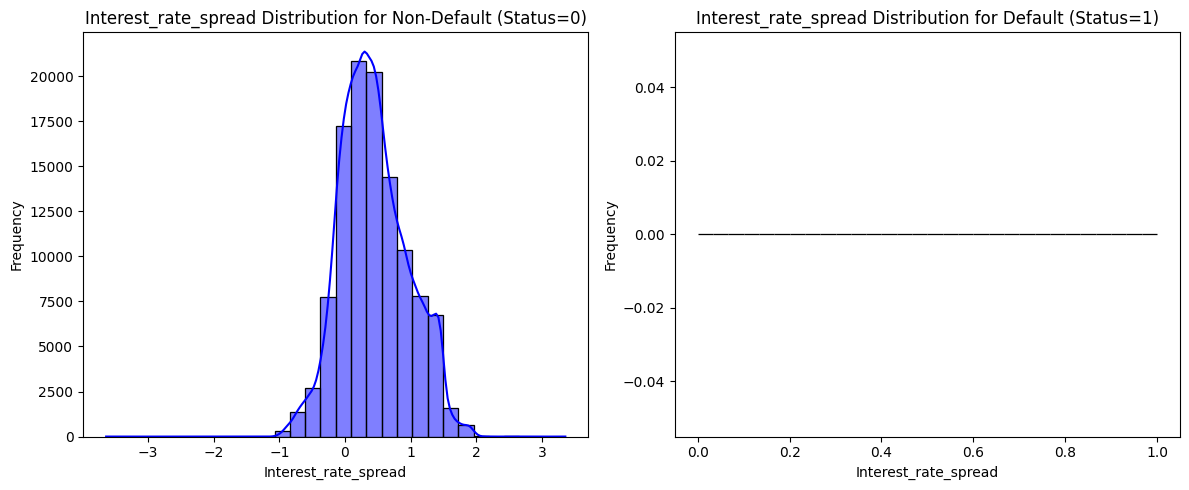

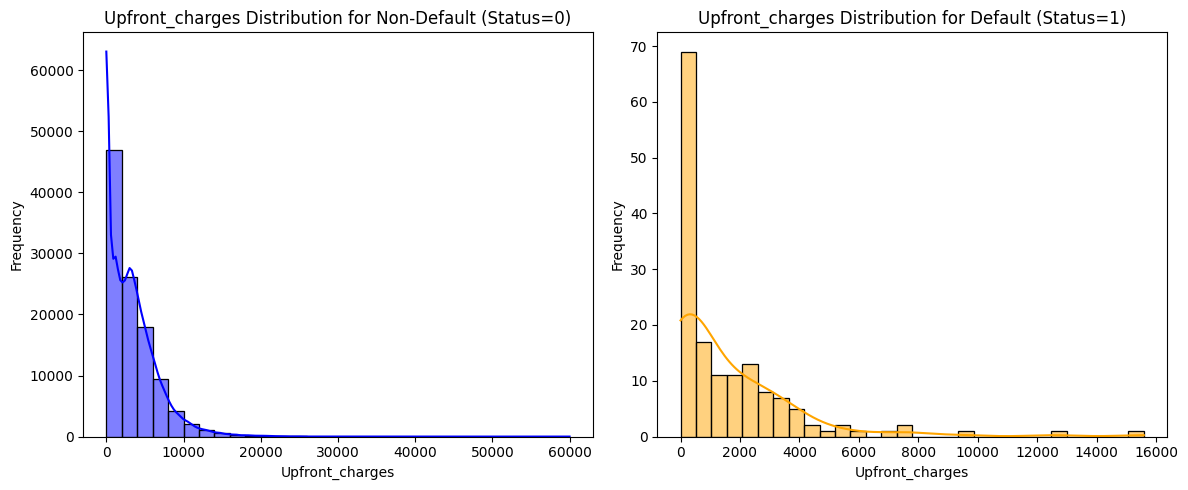

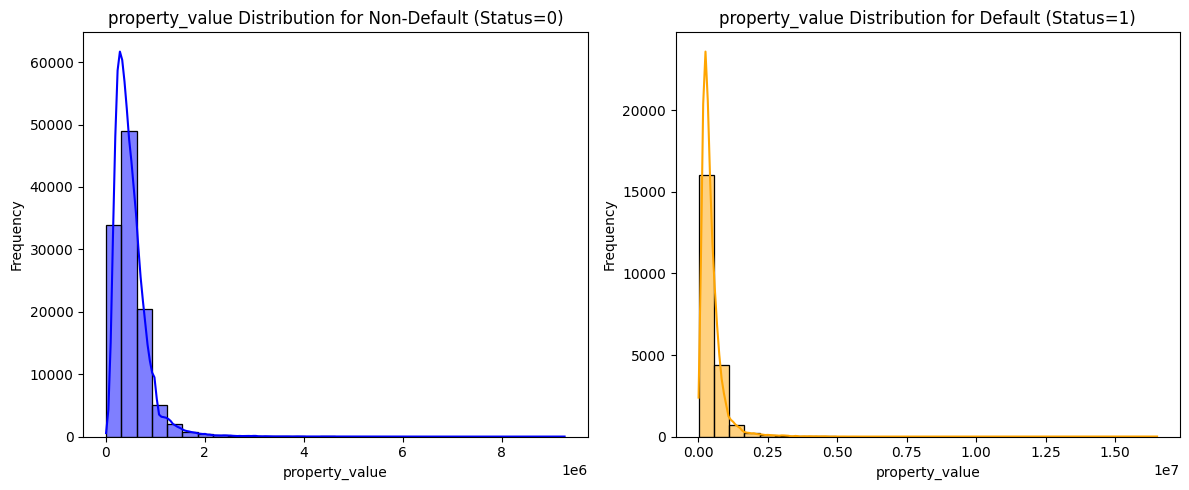

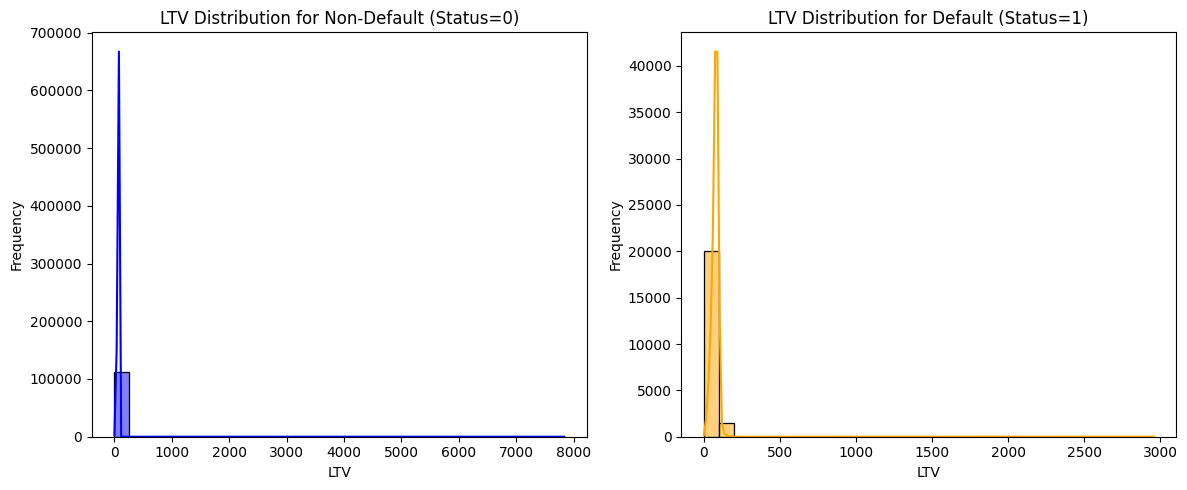

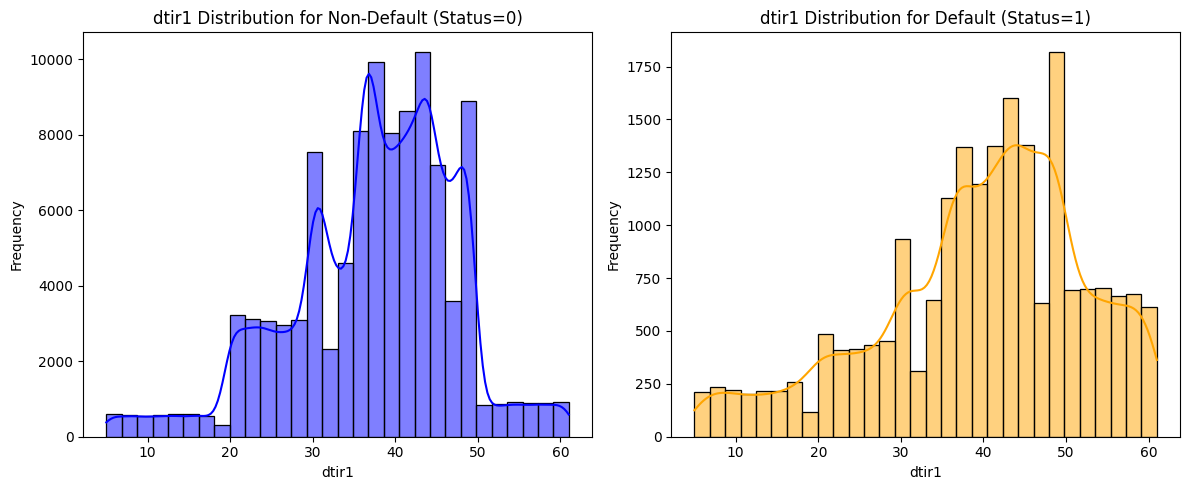

In [41]:
# List of KPIs to analyze
kpis_to_check = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'dtir1']

# Loop through each KPI to plot distributions for Status=0 and Status=1
for kpi in kpis_to_check:
    plt.figure(figsize=(12, 5))

    # Plot distribution for Non-Default Status (0)
    plt.subplot(1, 2, 1)
    sns.histplot(data[data['Status'] == 0][kpi], kde=True, bins=30, color='blue')
    plt.title(f'{kpi} Distribution for Non-Default (Status=0)')
    plt.xlabel(kpi)
    plt.ylabel('Frequency')

    # Plot distribution for Default Status (1)
    plt.subplot(1, 2, 2)
    sns.histplot(data[data['Status'] == 1][kpi], kde=True, bins=30, color='orange')
    plt.title(f'{kpi} Distribution for Default (Status=1)')
    plt.xlabel(kpi)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [42]:
# Initialize a dictionary for results
missing_percentage = {
    'KPI': [],
    'Missing_Percentage_Status_0': [],
    'Missing_Percentage_Status_1': []
}

# Calculate the percentage of missing values for each KPI, separated by Status 0 and 1
for kpi in kpis_to_check:
    missing_percentage['KPI'].append(kpi)
    missing_percentage['Missing_Percentage_Status_0'].append(data[data['Status'] == 0][kpi].isnull().mean() * 100)
    missing_percentage['Missing_Percentage_Status_1'].append(data[data['Status'] == 1][kpi].isnull().mean() * 100)

# Create a DataFrame from the dictionary and sort it by Missing_Percentage_Status_1 in descending order
missing_percentage_df = pd.DataFrame(missing_percentage).sort_values(by='Missing_Percentage_Status_1', ascending=False)

print("Percentage of missing values for Status 0 and 1")
print(missing_percentage_df)

Percentage of missing values for Status 0 and 1
                    KPI  Missing_Percentage_Status_0  \
1  Interest_rate_spread                     0.000000   
2       Upfront_charges                     2.817077   
0      rate_of_interest                     0.000000   
5                 dtir1                     6.972177   
3        property_value                     0.001785   
4                   LTV                     0.001785   

   Missing_Percentage_Status_1  
1                   100.000000  
2                    99.582412  
0                    99.454134  
5                    44.515407  
3                    41.201998  
4                    41.201998  


**Observations:**
1. Leakage Potential: I've observed that the variables `rate_of_interest`, `Interest_rate_spread`, and `Upfront_charges` have an extremely high percentage of missing values when `Status = 1` (loan defaults), close to 100%. This suggests that these variables may only apply to approved loans, potentially introducing leakage if I include them in the prediction model.
2. Information Imbalance: Given the lack of values for these features in default cases, they inherently differentiate between approved and defaulted loans. Including them could cause the model to rely on this imbalance, "leaking" information that wouldn't be available in a real predictive scenario.
3. Feature Strategy: To prevent this leakage, I’ll remove these variables from the feature set in the default prediction model. Instead, I could use them in a secondary model (e.g., a linear regression) to calculate interest-related metrics, but only if the first model approves the loan.

The three variables— `property_value`, `LTV`, and `dtir1` —show suspiciously high missing rates specifically when `Status = 1`, suggesting a potential pattern or data quality issue; further investigation is warranted to understand if these values are systematically unavailable for certain cases.

In [43]:
# Filter data for rows where Status is 1
status_1_data = data[data['Status'] == 1]

# Find rows with missing values in any of the three variables
missing_any_count = status_1_data[['property_value', 'LTV', 'dtir1']].isnull().any(axis=1).sum()

# Filter for rows where all three variables are missing
missing_all_count = status_1_data[['property_value', 'LTV', 'dtir1']].isnull().all(axis=1).sum()

# Calculate percentage of rows with missing values in all three among those with any missing
percentage_missing_all = (missing_all_count / missing_any_count) * 100

print(f"Percentage of rows with missing values in all three variables (property_value, LTV, and dtir1) "
      f"out of rows with at least one missing value: {percentage_missing_all:.2f}%")

Percentage of rows with missing values in all three variables (property_value, LTV, and dtir1) out of rows with at least one missing value: 92.56%


**Assumptions:**
1. No Collateral Requirement: Missing values for `property_value`, `LTV`, and `dtir1` might indicate loans without property collateral, where these metrics are unnecessary.
2. Loan Type: Certain types of loans (e.g., personal or short-term loans) may not require income or collateral verification, leaving these variables blank.
3. Special Applicant Conditions: Missing data may reflect specific applicant profiles, like high-creditworthiness individuals, where full verification is bypassed.

In [44]:
# 1. Check if loans without collateral requirement ('Secured_by' is NaN or a specific value) align with missing values in `property_value`, `LTV`, and `dtir1`.
collateral_check = data[
    (data['Status'] == 1) &
    (data[['property_value', 'LTV', 'dtir1']].isnull().all(axis=1))
]

collateral_summary = collateral_check['Secured_by'].value_counts(dropna=False)
print("Collateral Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(collateral_summary)

# 2. Analyze loan types for those with missing values in `property_value`, `LTV`, and `dtir1`.
loan_type_summary = collateral_check['loan_type'].value_counts(dropna=False)
loan_purpose_summary = collateral_check['loan_purpose'].value_counts(dropna=False)
print("\nLoan Type Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(loan_type_summary)
print("\nLoan Purpose Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(loan_purpose_summary)

# 3. Check if Credit Worthiness or advanced approval affects the missing values in `property_value`, `LTV`, and `dtir1`.
creditworthiness_summary = collateral_check['Credit_Worthiness'].value_counts(dropna=False)
approv_in_adv_summary = collateral_check['approv_in_adv'].value_counts(dropna=False)
print("\nCredit Worthiness Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(creditworthiness_summary)
print("\nApproval in Advance Summary for rows with missing `property_value`, `LTV`, and `dtir1`:")
print(approv_in_adv_summary)

Collateral Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
Secured_by
home    15096
Name: count, dtype: int64

Loan Type Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
loan_type
type1    11051
type2     2295
type3     1750
Name: count, dtype: int64

Loan Purpose Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
loan_purpose
p4     5397
p3     4909
p1     4433
p2      340
NaN      17
Name: count, dtype: int64

Credit Worthiness Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
Credit_Worthiness
l1    14236
l2      860
Name: count, dtype: int64

Approval in Advance Summary for rows with missing `property_value`, `LTV`, and `dtir1`:
approv_in_adv
nopre    12921
pre       2078
NaN         97
Name: count, dtype: int64


**Observation:**
Rows with missing values in `property_value`, `LTV`, and `dtir1` when `Status = 1` appear to have specific patterns:
1. Collateral Type: All missing entries are secured by "home," suggesting a simplified data requirement for these home-secured loans.
2. Loan Type and Purpose: Most missing values belong to `loan_type` "type1" and `loan_purpose` "p4," hinting that loans with these specifications might omit certain financial details.
3. Creditworthiness and Pre-Approval: The majority of these rows have high creditworthiness (`l1`) and lack pre-approval (`nopre`), suggesting that these loans might bypass extensive verification.
---
**Next Steps:**
- Dummy Variables: I’ll create dummy variables for `property_value` and `LTV` to mark missing values as distinct features, allowing the model to interpret these absences as potential risk signals.
- Selective Imputation: For loans without specific security types (e.g., not secured by "home"), I’ll impute missing values with `0`, signaling that property-related details were not relevant for these loans.

In [45]:
# Step 1: Create dummy variables for missing property_value and LTV
data['property_value_missing'] = data['property_value'].isnull().astype(int)
data['LTV_missing'] = data['LTV'].isnull().astype(int)

# Step 2: Impute missing values of property_value and LTV for loans not secured by "home"
# Setting property_value and LTV to 0 where secured type is not "home" and values are missing
data.loc[(data['property_value'].isnull()) & (data['Secured_by'] != 'home'), 'property_value'] = 0
data.loc[(data['LTV'].isnull()) & (data['Secured_by'] != 'home'), 'LTV'] = 0

# Verify the transformation
print("Sample of property_value and LTV related features after handling missing values:")
print(data[['property_value', 'LTV', 'property_value_missing', 'LTV_missing', 'Secured_by']].head())

Sample of property_value and LTV related features after handling missing values:
   property_value        LTV  property_value_missing  LTV_missing Secured_by
0        118000.0  98.728814                       0            0       home
1             NaN        NaN                       1            1       home
2        508000.0  80.019685                       0            0       home
3        658000.0  69.376900                       0            0       home
4        758000.0  91.886544                       0            0       home


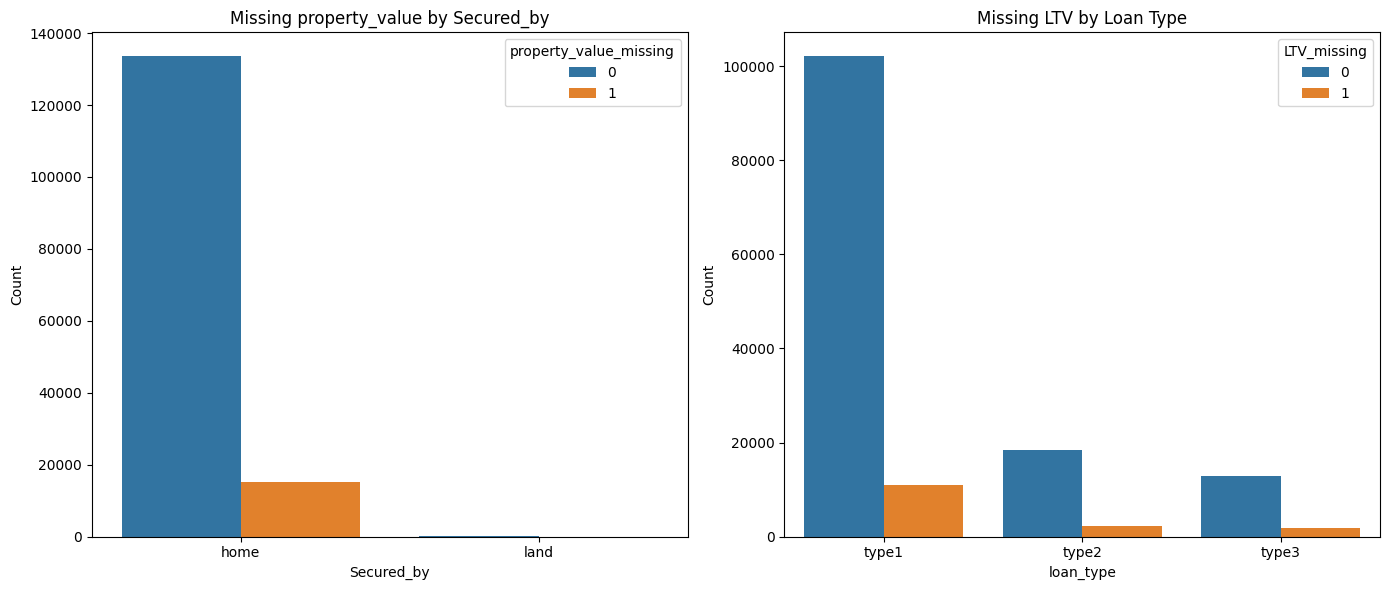

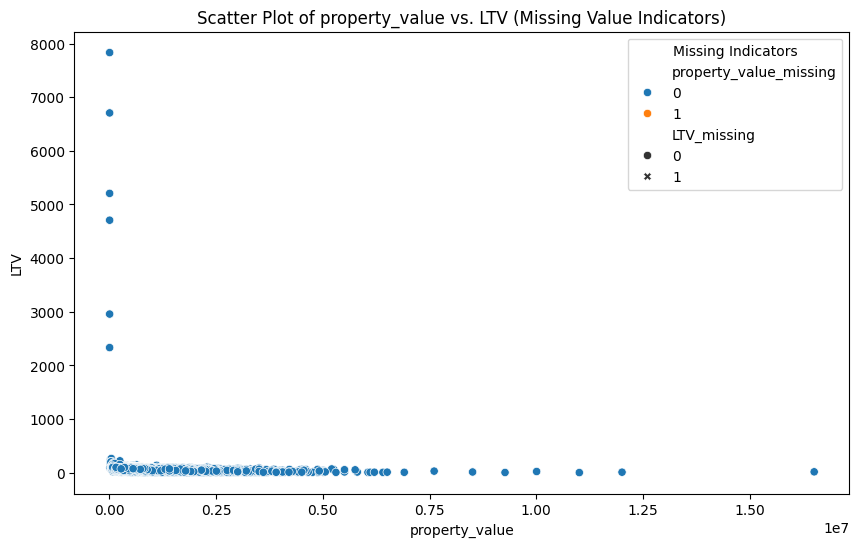

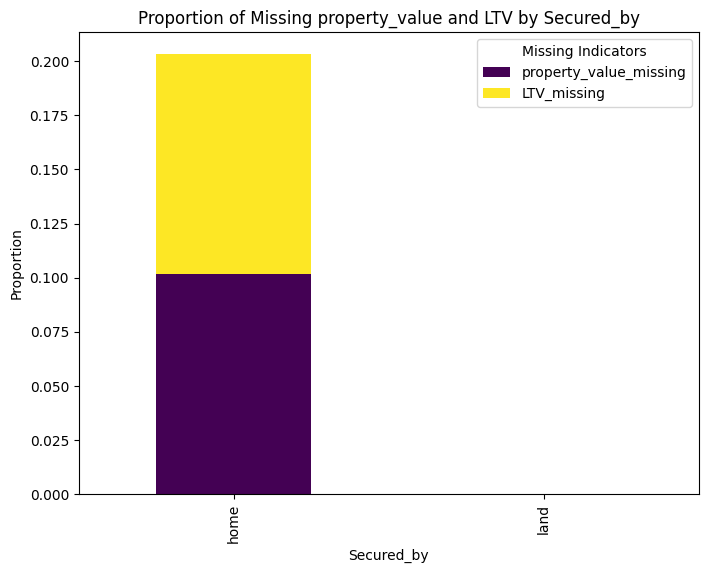

In [46]:
# 1. Bar Plot: Distribution of Missing Values in `property_value` and `LTV` by `Secured_by` and `loan_type`
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(data=data, x='Secured_by', hue='property_value_missing', ax=axes[0])
axes[0].set_title('Missing property_value by Secured_by')
axes[0].set_ylabel('Count')
axes[0].legend(title='property_value_missing')

sns.countplot(data=data, x='loan_type', hue='LTV_missing', ax=axes[1])
axes[1].set_title('Missing LTV by Loan Type')
axes[1].set_ylabel('Count')
axes[1].legend(title='LTV_missing')

plt.tight_layout()
plt.show()

# 2. Scatter Plot: property_value vs. LTV with color indicating missing values
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='property_value', y='LTV', hue='property_value_missing', style='LTV_missing')
plt.title('Scatter Plot of property_value vs. LTV (Missing Value Indicators)')
plt.xlabel('property_value')
plt.ylabel('LTV')
plt.legend(title='Missing Indicators')
plt.show()

# 3. Stacked Bar Plot: Proportion of missing indicators by Secured_by
missing_props = data.groupby('Secured_by')[['property_value_missing', 'LTV_missing']].mean()
missing_props.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='viridis')
plt.title('Proportion of Missing property_value and LTV by Secured_by')
plt.ylabel('Proportion')
plt.legend(title='Missing Indicators')
plt.show()

These patterns support the strategy to use dummy variables for missing values as potential indicators and selectively impute or ignore these missing values based on `Secured_by` and `loan_type`. Given these insights, the model could benefit from considering these missing indicators rather than imputing values universally, as they seem characteristic of certain loan profiles.

**`dtir1 dummy`:**

My intention is to create a dummy variable for missing values in `dtir1`, as the absence of this variable appears to correlate with loan defaults. By adding `dtir1_missing`, I aim to capture this potential risk signal and improve the model's predictive power by indicating cases with incomplete debt-to-income ratio information.

In [47]:
# Create a dummy variable for missing values in dtir1
data['dtir1_missing'] = data['dtir1'].isnull().astype(int)

# Sample check to confirm the creation of the dummy variable
print(data[['dtir1', 'dtir1_missing']].head())

   dtir1  dtir1_missing
0   45.0              0
1    NaN              1
2   46.0              0
3   42.0              0
4   39.0              0


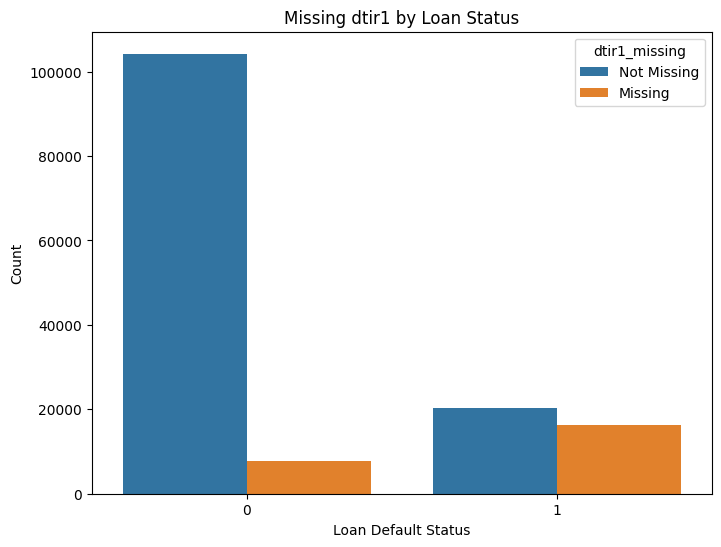

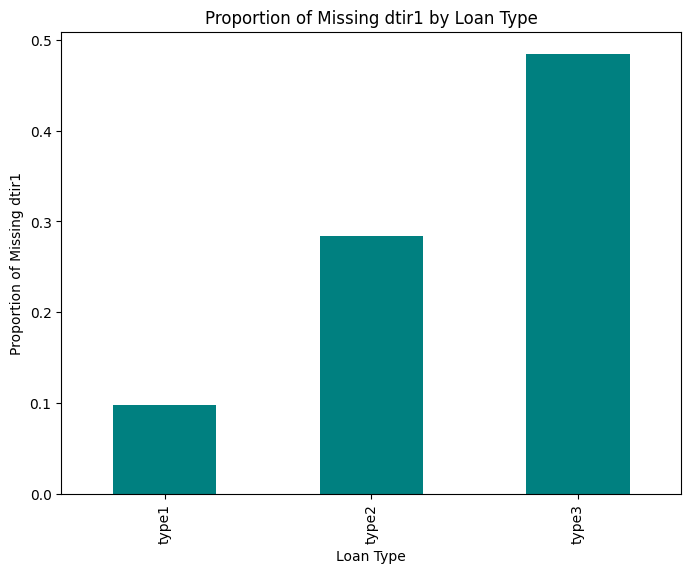

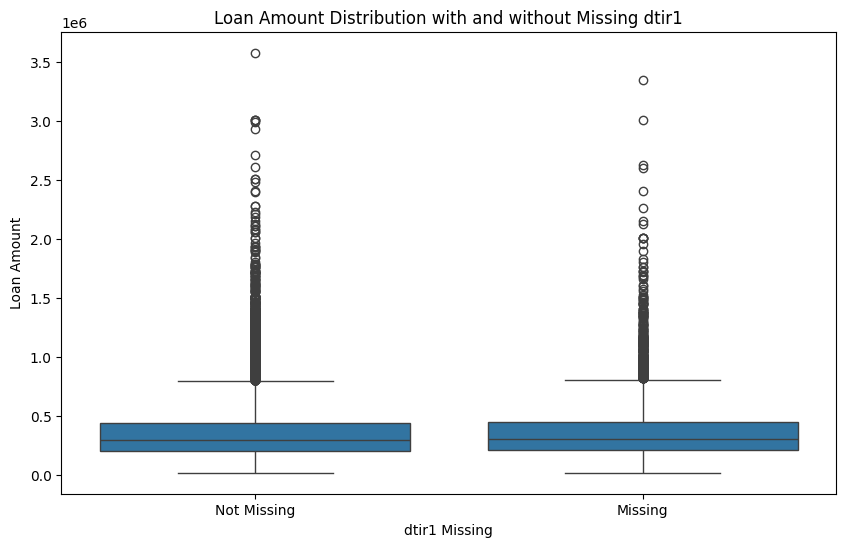

In [48]:
# 1. Bar Plot: Missing `dtir1` by Loan Status
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Status', hue='dtir1_missing')
plt.title("Missing dtir1 by Loan Status")
plt.xlabel("Loan Default Status")
plt.ylabel("Count")
plt.legend(title="dtir1_missing", labels=['Not Missing', 'Missing'])
plt.show()

# 2. Stacked Bar Plot: Proportion of Missing `dtir1` by Loan Type
dtir1_missing_props = data.groupby('loan_type')['dtir1_missing'].mean()
dtir1_missing_props.plot(kind='bar', stacked=True, figsize=(8, 6), color='teal')
plt.title('Proportion of Missing dtir1 by Loan Type')
plt.ylabel('Proportion of Missing dtir1')
plt.xlabel('Loan Type')
plt.show()

# 3. Box Plot: Loan Amount Distribution with and without Missing dtir1
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='dtir1_missing', y='loan_amount')
plt.title('Loan Amount Distribution with and without Missing dtir1')
plt.xlabel('dtir1 Missing')
plt.ylabel('Loan Amount')
plt.xticks([0, 1], ['Not Missing', 'Missing'])
plt.show()

**Interpretation and Next Steps**
These patterns reinforce the decision to retain the `dtir1_missing` dummy variable in the model, as the absence of `dtir1` seems linked to higher-risk loan characteristics, especially for certain loan types and defaulted loans. This indicator could add predictive value by helping the model recognize cases with incomplete debt-to-income information as potentially higher-risk.

# 2. Explore Remaining Variables

In [49]:
# List of variables to exclude from the missing summary
exclude_vars = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'dtir1']

# Calculate missing values and percentages
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# Missing values summary excluding specified variables
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
}).drop(exclude_vars, errors='ignore')

# Filter to show only columns with at least 1 missing value and sort
missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

print(missing_summary)

                           Missing Values  Percentage (%)
income                               9150        6.154571
loan_limit                           3344        2.249277
approv_in_adv                         908        0.610749
age                                   200        0.134526
submission_of_application             200        0.134526
loan_purpose                          134        0.090133
Neg_ammortization                     121        0.081388
term                                   41        0.027578


### 2.1 Income

In [50]:
# Check for patterns in missing income values
missing_income_data = data[data['income'].isnull()]

# Display summary of relevant categorical variables when income is missing
categorical_summary = missing_income_data.describe(include='object')
print("Categorical Summary for rows with missing income:")
print(categorical_summary)

# Display summary of relevant numerical variables when income is missing
numerical_summary = missing_income_data.describe()
print("\nNumerical Summary for rows with missing income:")
print(numerical_summary)

Categorical Summary for rows with missing income:
       loan_limit Gender approv_in_adv loan_type loan_purpose  \
count        9054   9150          9119      9150         9142   
unique          2      4             2         3            4   
top            cf  Joint         nopre     type3           p4   
freq         8178   2970          8196      5403         8897   

       Credit_Worthiness open_credit business_or_commercial Neg_ammortization  \
count               9150        9150                   9150              9149   
unique                 2           1                      2                 2   
top                   l1        nopc                  nob/c           not_neg   
freq                9003        9150                   5544              8700   

       interest_only  ... construction_type occupancy_type Secured_by  \
count           9150  ...              9150           9150       9150   
unique             2  ...                 2              3          2   

**Observation:**

The missing income values are associated with a specific distribution across several categorical variables. Notably, these rows predominantly feature loans that are not pre-approved (`nopre`), are secured by `home`, and are often classified under `type3` loan type and purpose `p4`. Additionally, a large portion shows a high `Credit_Worthiness` rating of `l1` and belongs to applicants from the `North` region. These patterns suggest that missing income might relate to particular loan or customer characteristics.

**Assumptions:**
1. Certain Loan Types: Some loans may have been approved without knowing the applicant's income, relying instead on other securities or a co-signer to back the loan.
2. Specific Credit Types: These missing income entries could be linked to particular types of loans, such as commercial loans, where personal income may not be required.
3. Unique Customer Profiles: These loans could belong to customers with specific profiles for whom detailed income data was either unavailable or not required.

In [51]:
# Filter rows with missing income
missing_income_data = data[data['income'].isnull()]

# Step 1: Summary of key variables for rows with missing income
print("Summary for rows with missing income:")
print(missing_income_data[['loan_type', 'Credit_Worthiness', 'Secured_by', 'business_or_commercial']].describe(include='all'))

# Step 2: Segment dataset based on income availability
with_income_data = data[data['income'].notnull()]
without_income_data = data[data['income'].isnull()]

# Step 3: Calculate proportions for relevant variables in both segments
def calculate_proportions(df, column):
    return df[column].value_counts(normalize=True) * 100

# Calculate and compare distributions for 'loan_type' and 'Credit_Worthiness'
print("\nProportion of loan_type for rows WITH income:")
print(calculate_proportions(with_income_data, 'loan_type'))

print("\nProportion of loan_type for rows WITHOUT income:")
print(calculate_proportions(without_income_data, 'loan_type'))

print("\nProportion of Credit_Worthiness for rows WITH income:")
print(calculate_proportions(with_income_data, 'Credit_Worthiness'))

print("\nProportion of Credit_Worthiness for rows WITHOUT income:")
print(calculate_proportions(without_income_data, 'Credit_Worthiness'))

# Step 4: Check specific profiles, such as 'business_or_commercial'
print("\nProportion of 'business_or_commercial' for rows WITHOUT income:")
print(calculate_proportions(without_income_data, 'business_or_commercial'))

Summary for rows with missing income:
       loan_type Credit_Worthiness Secured_by business_or_commercial
count       9150              9150       9150                   9150
unique         3                 2          2                      2
top        type3                l1       home                  nob/c
freq        5403              9003       9147                   5544

Proportion of loan_type for rows WITH income:
loan_type
type1    81.014908
type2    12.296445
type3     6.688647
Name: proportion, dtype: float64

Proportion of loan_type for rows WITHOUT income:
loan_type
type3    59.049180
type2    39.409836
type1     1.540984
Name: proportion, dtype: float64

Proportion of Credit_Worthiness for rows WITH income:
Credit_Worthiness
l1    95.571244
l2     4.428756
Name: proportion, dtype: float64

Proportion of Credit_Worthiness for rows WITHOUT income:
Credit_Worthiness
l1    98.393443
l2     1.606557
Name: proportion, dtype: float64

Proportion of 'business_or_commercial' f

**Observations and Next Steps for Handling Missing Income Data:**
1. Verify Pattern Consistency: It appears that loans with high creditworthiness (Credit Worthiness "l1") often lack income data, possibly due to a reduced risk assessment requirement. I will further investigate if all loans with missing income data have this "l1" creditworthiness to confirm this pattern.
2. Feature Engineering Opportunity: Based on this observation, I can create a new indicator feature that flags cases where Credit Worthiness is "l1" and income data is missing. This feature may capture relevant risk information without relying directly on income values.
3. Handling in Modeling: If confirmed, I may choose to treat missing income values for "l1" cases differently, perhaps filling them with a placeholder or marking them as “not needed.” This approach allows the model to interpret this as a specific risk-related signal rather than a missing value.
4. Consider Excluding Income Data: If Credit Worthiness and Loan Type can sufficiently capture risk without income information, I could remove income data for "l1" cases to avoid redundancy and potential data leakage. This could simplify the model and improve interpretability.

In [52]:
#Step 1
# Filter rows with missing income
missing_income_data = data[data['income'].isnull()]

# Calculate the proportion of Credit Worthiness levels in rows with missing income
credit_worthiness_proportion = missing_income_data['Credit_Worthiness'].value_counts(normalize=True) * 100

# Display the results
print("Proportion of Credit Worthiness levels for rows with missing income:")
print(credit_worthiness_proportion)

Proportion of Credit Worthiness levels for rows with missing income:
Credit_Worthiness
l1    98.393443
l2     1.606557
Name: proportion, dtype: float64


In [53]:
#Step 2: Check for Additional Factors or Correlated Features
# Analyze 'loan_type' proportions in rows with missing income
loan_type_missing_income = missing_income_data['loan_type'].value_counts(normalize=True) * 100
print("Proportion of loan_type for rows WITH missing income:")
print(loan_type_missing_income)

# Analyze 'loan_type' proportions in rows with income
loan_type_with_income = data[data['income'].notnull()]['loan_type'].value_counts(normalize=True) * 100
print("\nProportion of loan_type for rows WITHOUT missing income:")
print(loan_type_with_income)

# Analyze 'business_or_commercial' proportions in rows with missing income
business_commercial_missing_income = missing_income_data['business_or_commercial'].value_counts(normalize=True) * 100
print("\nProportion of business_or_commercial for rows WITH missing income:")
print(business_commercial_missing_income)

# Analyze 'business_or_commercial' proportions in rows with income
business_commercial_with_income = data[data['income'].notnull()]['business_or_commercial'].value_counts(normalize=True) * 100
print("\nProportion of business_or_commercial for rows WITHOUT missing income:")
print(business_commercial_with_income)

Proportion of loan_type for rows WITH missing income:
loan_type
type3    59.049180
type2    39.409836
type1     1.540984
Name: proportion, dtype: float64

Proportion of loan_type for rows WITHOUT missing income:
loan_type
type1    81.014908
type2    12.296445
type3     6.688647
Name: proportion, dtype: float64

Proportion of business_or_commercial for rows WITH missing income:
business_or_commercial
nob/c    60.590164
b/c      39.409836
Name: proportion, dtype: float64

Proportion of business_or_commercial for rows WITHOUT missing income:
business_or_commercial
nob/c    87.703555
b/c      12.296445
Name: proportion, dtype: float64


**Intention:** I want to handle missing income values by creating a dummy variable that flags missing income as a distinct feature and by selectively imputing income for high-creditworthy applicants. This approach allows my model to interpret missing income as a potential signal rather than a simple absence of data.

In [54]:
# Step 1: Create a dummy variable for missing income values
data['income_missing'] = data['income'].isnull().astype(int)

# Step 2: Fill missing income values with 0 for high creditworthiness levels (l1),
# assuming income verification might not be required for this group
data.loc[(data['income'].isnull()) & (data['Credit_Worthiness'] == 'l1'), 'income'] = 0

# Step 3: Verify the transformation
print("Sample of income-related features after handling missing values:")
print(data[['income', 'income_missing', 'Credit_Worthiness']].head())

Sample of income-related features after handling missing values:
    income  income_missing Credit_Worthiness
0   1740.0               0                l1
1   4980.0               0                l1
2   9480.0               0                l1
3  11880.0               0                l1
4  10440.0               0                l1


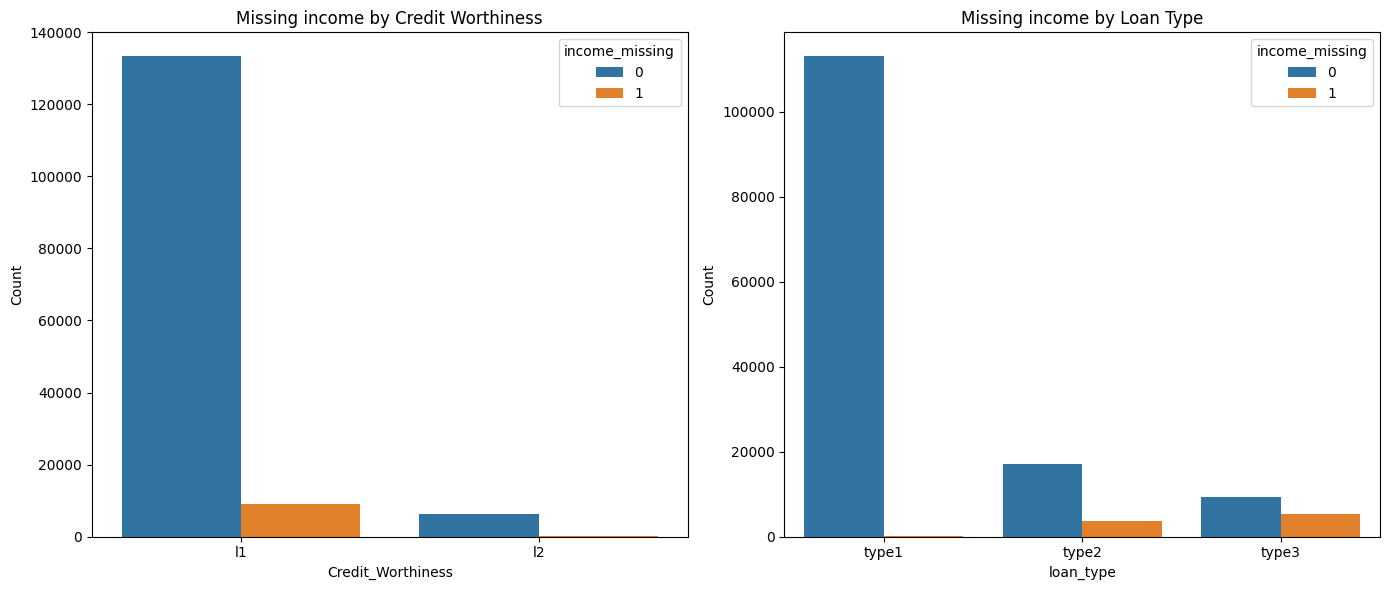

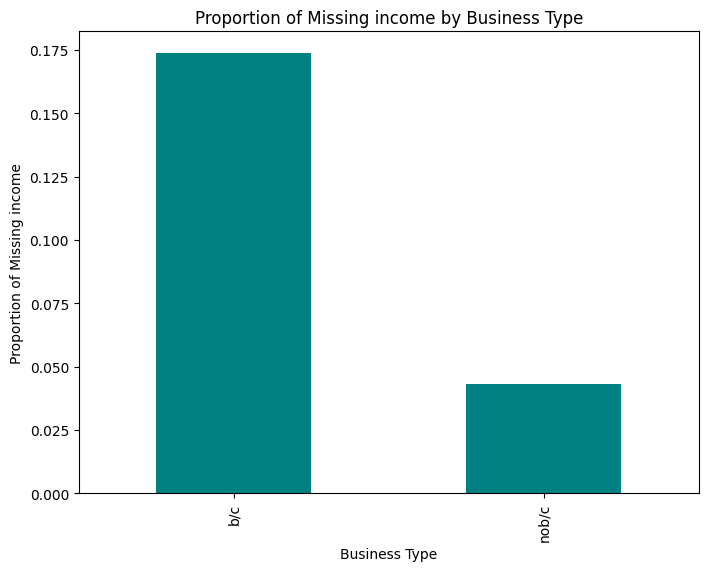

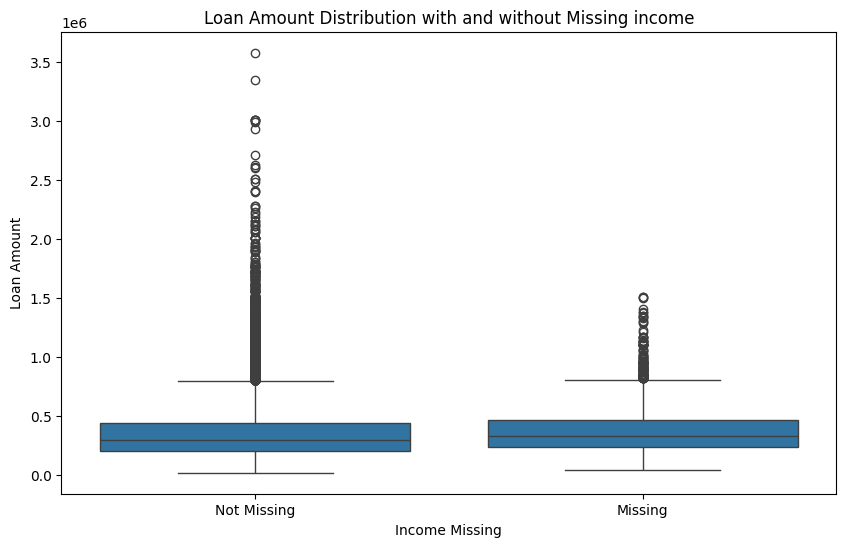

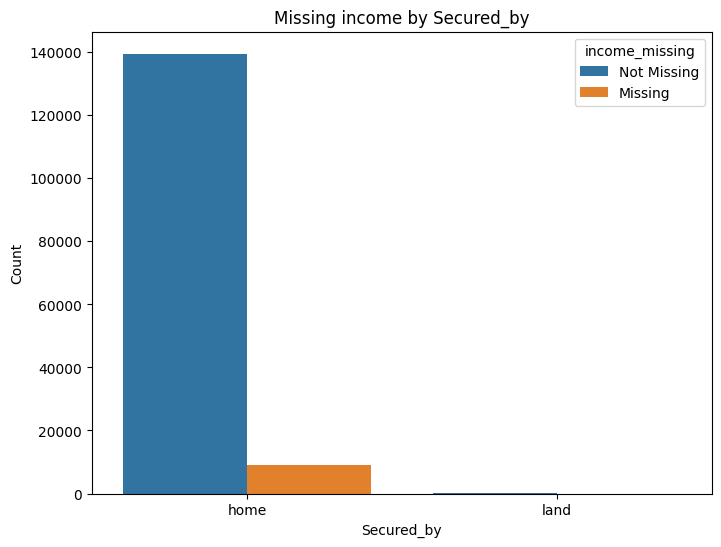

In [55]:
# 1. Bar Plot: Missing `income` by Creditworthiness and Loan Type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(data=data, x='Credit_Worthiness', hue='income_missing', ax=axes[0])
axes[0].set_title('Missing income by Credit Worthiness')
axes[0].set_ylabel('Count')
axes[0].legend(title='income_missing')

sns.countplot(data=data, x='loan_type', hue='income_missing', ax=axes[1])
axes[1].set_title('Missing income by Loan Type')
axes[1].set_ylabel('Count')
axes[1].legend(title='income_missing')

plt.tight_layout()
plt.show()

# 2. Stacked Bar Plot: Proportion of Missing `income` by Business Type
income_missing_props = data.groupby('business_or_commercial')['income_missing'].mean()
income_missing_props.plot(kind='bar', stacked=True, figsize=(8, 6), color='teal')
plt.title('Proportion of Missing income by Business Type')
plt.ylabel('Proportion of Missing income')
plt.xlabel('Business Type')
plt.show()

# 3. Box Plot: Loan Amount Distribution with and without Missing `income`
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='income_missing', y='loan_amount')
plt.title('Loan Amount Distribution with and without Missing income')
plt.xlabel('Income Missing')
plt.ylabel('Loan Amount')
plt.xticks([0, 1], ['Not Missing', 'Missing'])
plt.show()

# 4. Count Plot: Missing income by Secured_by
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Secured_by', hue='income_missing')
plt.title('Missing income by Secured_by')
plt.ylabel('Count')
plt.legend(title='income_missing', labels=['Not Missing', 'Missing'])
plt.show()

The visualizations reveal that missing income values are more common for high-creditworthy applicants, certain loan types (especially type1), and business loans. This pattern suggests that missing income itself holds predictive value, as it often aligns with specific loan characteristics. Consequently, I’ll retain the `income_missing` indicator and consider imputing income selectively, particularly for high-creditworthy or business loan applicants, to preserve this signal in the model.

# 3. Feature Fine Tuning

### Create interest_income_ratio

The intention behind creating the `interest_income_ratio` feature is to quantify the portion of the borrower’s income that is dedicated to interest payments. This metric helps to assess the financial burden of the loan on the borrower, which could indicate higher risk levels for those with a significant share of their income going towards interest. By incorporating this ratio, we aim to improve the model's ability to predict loan defaults by capturing an important aspect of financial strain.

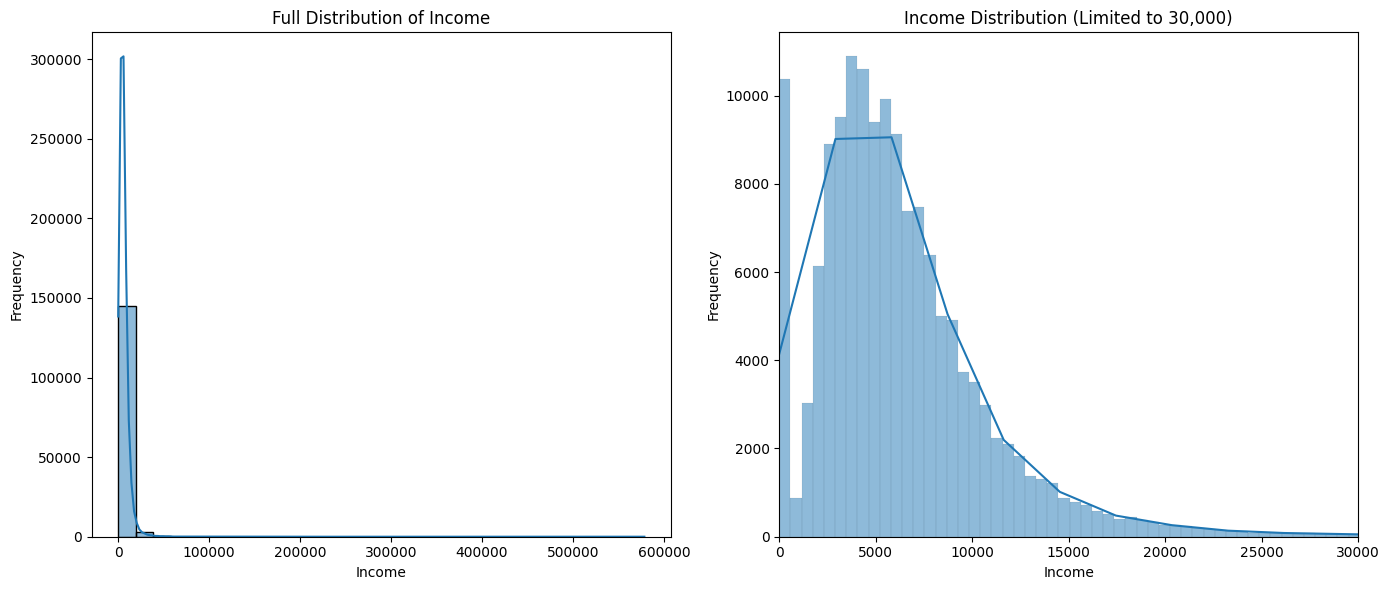

In [56]:
# Set up the subplot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full income distribution
sns.histplot(data['income'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Full Distribution of Income")
axes[0].set_xlabel("Income")
axes[0].set_ylabel("Frequency")

# Income distribution with x-axis limited to 30,000
sns.histplot(data['income'], bins=1000, kde=True, ax=axes[1])
axes[1].set_title("Income Distribution (Limited to 30,000)")
axes[1].set_xlabel("Income")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0, 30000)  # Set x-axis limit to 30,000

plt.tight_layout()
plt.show()

In [57]:
# Calculate `interest_income_ratio` and set to 0 where `income` is zero
data['interest_income_ratio'] = np.where(
    data['income'] > 0,  # Only calculate for positive income values
    (data['rate_of_interest'] * data['loan_amount']) / data['income'],
    0  # Set to 0 for rows with income = 0
)

In [58]:
# Select the top 10 highest interest_income_ratio values with corresponding columns
top_10_ratios = data.nlargest(10, 'interest_income_ratio')[['interest_income_ratio', 'rate_of_interest', 'loan_amount', 'income', 'Status']]

# Display the top 10 values
print(top_10_ratios)

        interest_income_ratio  rate_of_interest  loan_amount  income  Status
43079            18750.520833             4.625       486500   120.0       0
97078            18750.520833             4.625       486500   120.0       0
102942            6231.640625             5.375       556500   480.0       0
55968             2965.625000             4.875       766500  1260.0       0
54421             2409.062500             4.875       296500   600.0       0
71495             2054.092262             4.750       726500  1680.0       0
13604             2046.093750             4.500       436500   960.0       0
106473            1860.085227             5.625       436500  1320.0       0
88927             1823.708333             5.190       126500   360.0       0
81221             1801.078125             4.990       346500   960.0       0


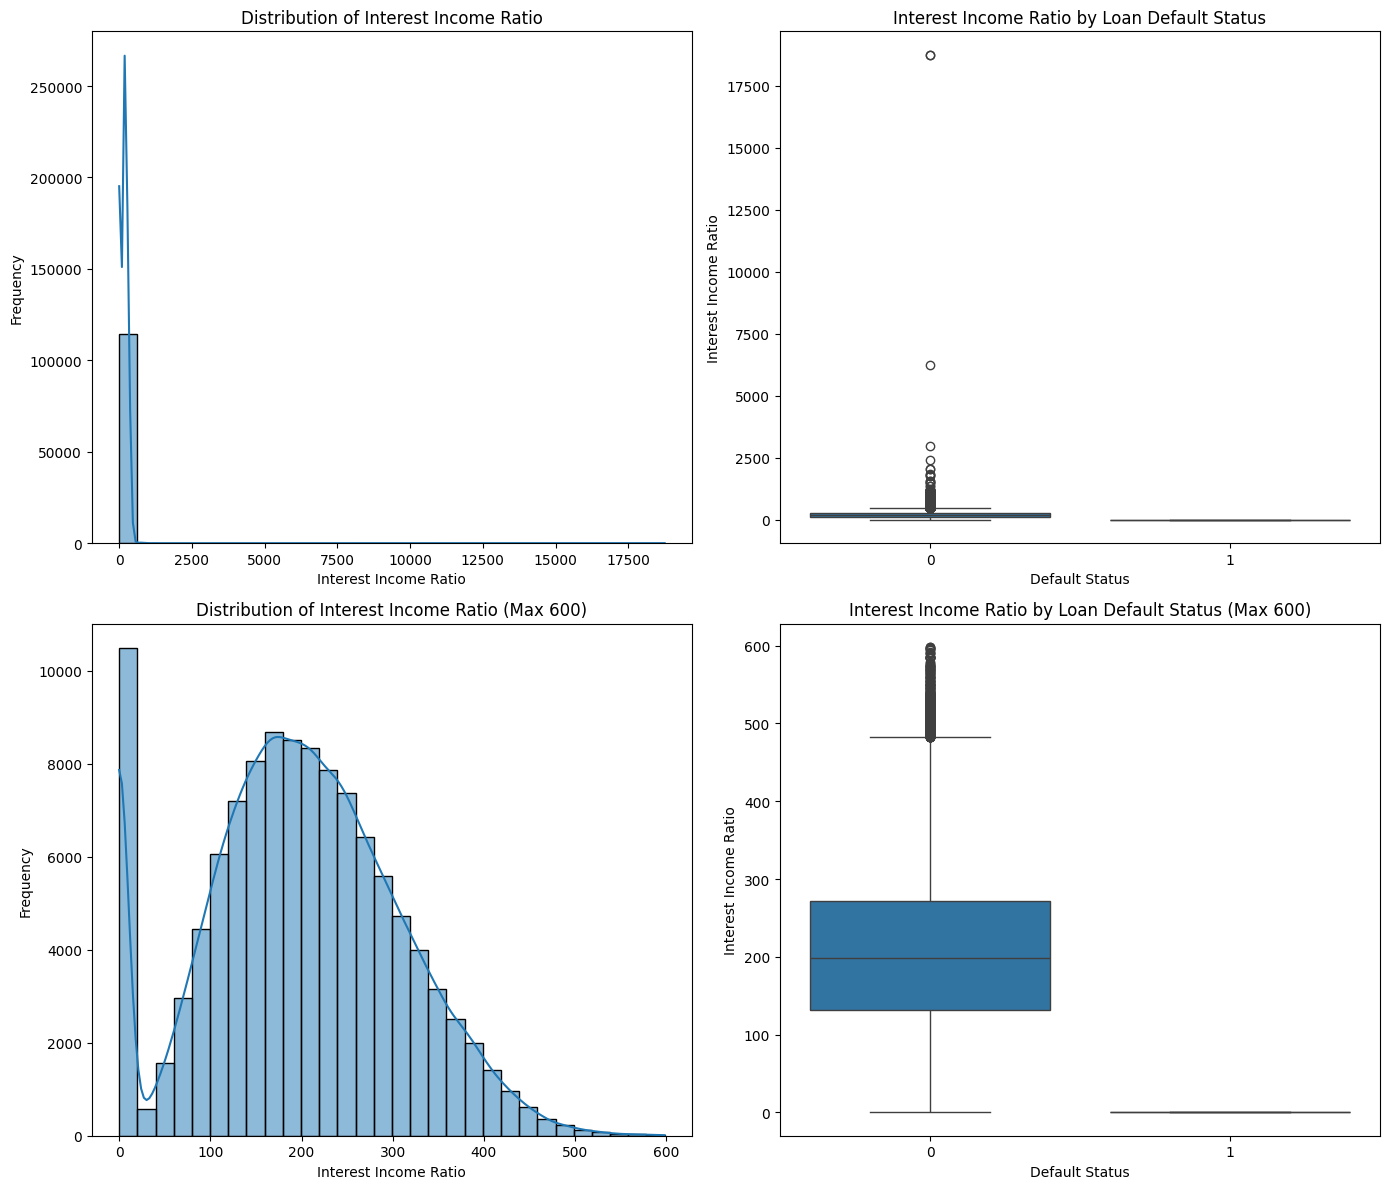

In [59]:
# Set up the subplot grid with two rows and two columns
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original distribution of interest_income_ratio
sns.histplot(data['interest_income_ratio'], kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Interest Income Ratio")
axes[0, 0].set_xlabel("Interest Income Ratio")
axes[0, 0].set_ylabel("Frequency")

# Original boxplot of interest_income_ratio by Status
sns.boxplot(x='Status', y='interest_income_ratio', data=data, ax=axes[0, 1])
axes[0, 1].set_title("Interest Income Ratio by Loan Default Status")
axes[0, 1].set_xlabel("Default Status")
axes[0, 1].set_ylabel("Interest Income Ratio")

# Limited distribution of interest_income_ratio (max 600)
sns.histplot(data[data['interest_income_ratio'] <= 600]['interest_income_ratio'], kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Interest Income Ratio (Max 600)")
axes[1, 0].set_xlabel("Interest Income Ratio")
axes[1, 0].set_ylabel("Frequency")

# Limited boxplot of interest_income_ratio by Status (max 600)
sns.boxplot(x='Status', y='interest_income_ratio', data=data[data['interest_income_ratio'] <= 600], ax=axes[1, 1])
axes[1, 1].set_title("Interest Income Ratio by Loan Default Status (Max 600)")
axes[1, 1].set_xlabel("Default Status")
axes[1, 1].set_ylabel("Interest Income Ratio")

plt.tight_layout()
plt.show()

**Intention**: My goal is to create a dummy variable for missing `income` values, capturing the potential significance of missing income information as a risk indicator. This approach allows the model to interpret the absence of `income` as a distinct feature, which may be relevant to predicting loan defaults.

In [64]:
# Create a dummy variable to indicate missing income values
data['income_missing'] = data['income'].isnull().astype(int)

# Sample check to confirm the creation of the dummy variable
print(data[['income', 'income_missing']].head())

    income  income_missing
0   1740.0               0
1   4980.0               0
2   9480.0               0
3  11880.0               0
4  10440.0               0


### Drop Columns (OUTDATED)

Goal: Identify pairs of features with high correlation (e.g., correlation > 0.85). If two features are highly correlated, keeping both may not add value.

In [61]:
# Calculate absolute correlation matrix for numeric features
#corr_matrix = data.select_dtypes(include=[np.number]).corr().abs()

# Extract pairs of highly correlated features
#high_corr_pairs = [
#    (i, j, corr_matrix.loc[i, j]) for i in corr_matrix.columns for j in corr_matrix.columns
#    if i != j and corr_matrix.loc[i, j] > 0.55
#]

# Create DataFrame to display high correlation pairs and their correlation values
#high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature_1', 'Feature_2', 'Correlation_Value']).drop_duplicates()
#high_corr_df.sort_values(by='Correlation_Value', ascending=False, inplace=True)
#print(high_corr_df)

`Loan Amount` and `Property Value`: Keep both features initially, as they might each contribute to the model in slightly different ways. We could later consider removing one if further analysis (like feature importance) shows one is consistently less predictive.

`Rate of Interest` and `Interest Rate Spread`: Keep both features for now, as they may offer complementary insights into loan risk. However, if either shows low importance or appears redundant in model tuning, we could consider dropping it.

# 4. Preprocessing

In [5]:
# Restore the original data
data = data_backup.copy()

In [6]:
# Import the function from preprocessor_v2.py
from package_folder.preprocessor_v2 import create_preprocessing_pipeline

In [ ]:
#import importlib
#import package_folder.preprocessor_v2
#importlib.reload(package_folder.preprocessor_v2)

<module 'package_folder.preprocessor_v2' from '/Users/giliamo/code/YannAll/automated_loan_review_project/package_folder/preprocessor_v2.py'>

In [7]:
# Apply the preprocessor
pipeline = create_preprocessing_pipeline()
data_processed = pipeline.fit_transform(data)

In [8]:
data_processed.head()

,loan_amount,rate_of_interest,property_value,income,Credit_Score,LTV,Status,dtir1,interest_income_ratio,LTV_missing,...,age_missing,submission_of_application_missing,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,0.087719,0.466182,0.060827,0.076558,0.6450,0.574193,1.0,0.741935,0.217147,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.166667,0.503030,0.260341,0.219032,0.1300,0.000000,1.0,0.000000,0.191858,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.342105,0.590303,0.298054,0.416912,0.8350,0.466474,0.0,0.758065,0.310965,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.385965,0.515152,0.389294,0.522448,0.2175,0.405198,0.0,0.693548,0.259982,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.596491,0.454545,0.450122,0.459127,0.2550,0.534798,0.0,0.645161,0.423823,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# 5. Analyze Prerprocessed Data

In [9]:
data_processed.shape

(144808, 104)

In [10]:
# Count the number of variables by data type
data_types_count = data_processed.dtypes.value_counts()

print(data_types_count)

float64    104
Name: count, dtype: int64


In [11]:
# Count variables (columns) where all values are between 0 and 1
variables_between_0_and_1 = ((data_processed >= 0) & (data_processed <= 1)).all(axis=0).sum()

# Count variables (columns) where at least one value is less than 0
variables_less_than_0 = (data_processed < 0).any(axis=0).sum()

# Count variables (columns) where at least one value is greater than 1
variables_greater_than_1 = (data_processed > 1).any(axis=0).sum()

# Display the counts
print(f"Variables with all values between 0 and 1: {variables_between_0_and_1}")
print(f"Variables with at least one value less than 0: {variables_less_than_0}")
print(f"Variables with at least one value greater than 1: {variables_greater_than_1}")

Variables with all values between 0 and 1: 104
Variables with at least one value less than 0: 0
Variables with at least one value greater than 1: 0


In [12]:
# Count the occurrences of each value in the 'Status' column
status_counts = data_processed['Status'].value_counts()

# Display the counts
print(f"Occurrences of Status = 0: {status_counts.get(0, 0)}")
print(f"Occurrences of Status = 1: {status_counts.get(1, 0)}")

Occurrences of Status = 0: 109190
Occurrences of Status = 1: 35618


In [13]:
data_processed.columns

Index(['loan_amount', 'rate_of_interest', 'property_value', 'income',
       'Credit_Score', 'LTV', 'Status', 'dtir1', 'interest_income_ratio',
       'LTV_missing',
       ...
       'age_missing', 'submission_of_application_missing',
       'submission_of_application_not_inst',
       'submission_of_application_to_inst', 'Region_North',
       'Region_North-East', 'Region_central', 'Region_south',
       'Security_Type_Indriect', 'Security_Type_direct'],
      dtype='object', length=104)

In [14]:
# General information about the dataset
print(data_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144808 entries, 0 to 144807
Columns: 104 entries, loan_amount to Security_Type_direct
dtypes: float64(104)
memory usage: 114.9 MB
None


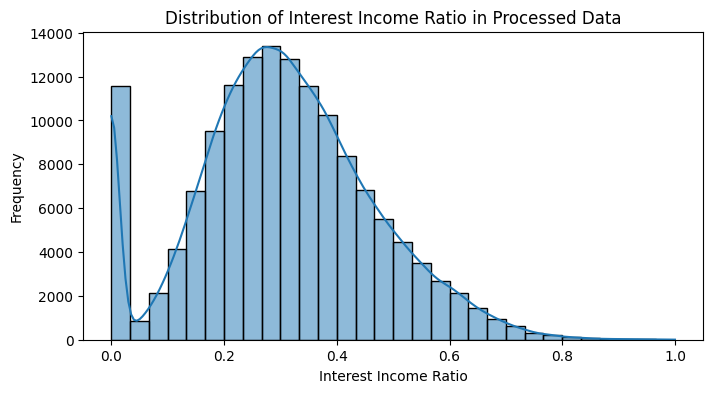

In [15]:
# Plot the distribution of the interest_income_ratio feature
plt.figure(figsize=(8, 4))
sns.histplot(data_processed['interest_income_ratio'], kde=True, bins=30)
plt.title("Distribution of Interest Income Ratio in Processed Data")
plt.xlabel("Interest Income Ratio")
plt.ylabel("Frequency")
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Define X and y for the model
X = data_processed.drop(columns=['Status'])
y = data_processed['Status']

# Train a RandomForest model to get feature importances
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Create a DataFrame of feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display features with lowest importance
print("Least important features:")
print(feature_importances.tail())
print("Most important features:")
print(feature_importances.head())

Least important features:
       Feature    Importance
43  term_192.0  1.394081e-05
55  term_322.0  2.191081e-06
48  term_252.0  1.824443e-06
51  term_280.0  5.246926e-07
40  term_165.0  0.000000e+00
Most important features:
                  Feature  Importance
5                     LTV    0.141082
7   interest_income_ratio    0.102208
1        rate_of_interest    0.097459
82       credit_type_EQUI    0.096982
6                   dtir1    0.082381


In [17]:
# List of columns that should have been dropped
columns_to_drop = ['year', 'ID', 'Interest_rate_spread', 'Upfront_charges']

# Check if any of these columns are still in the processed data
remaining_columns = [col for col in columns_to_drop if col in data_processed.columns]

if remaining_columns:
    print(f"The following columns were not dropped: {remaining_columns}")
else:
    print("All specified columns were successfully dropped.")

All specified columns were successfully dropped.


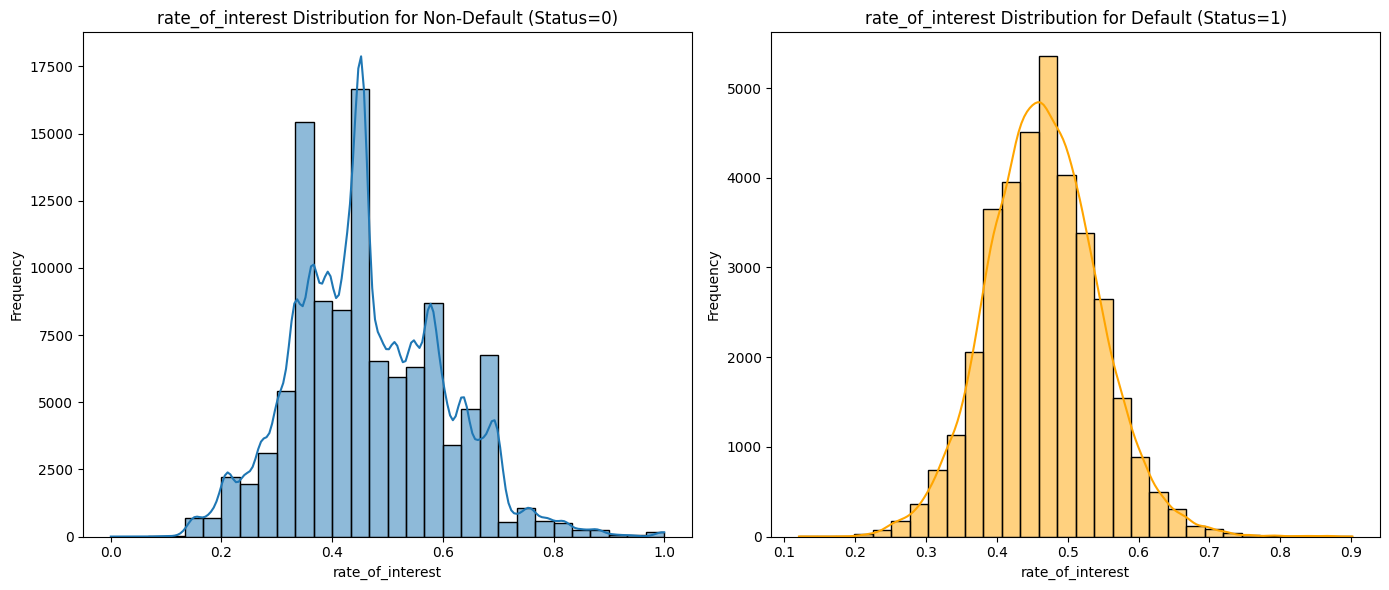

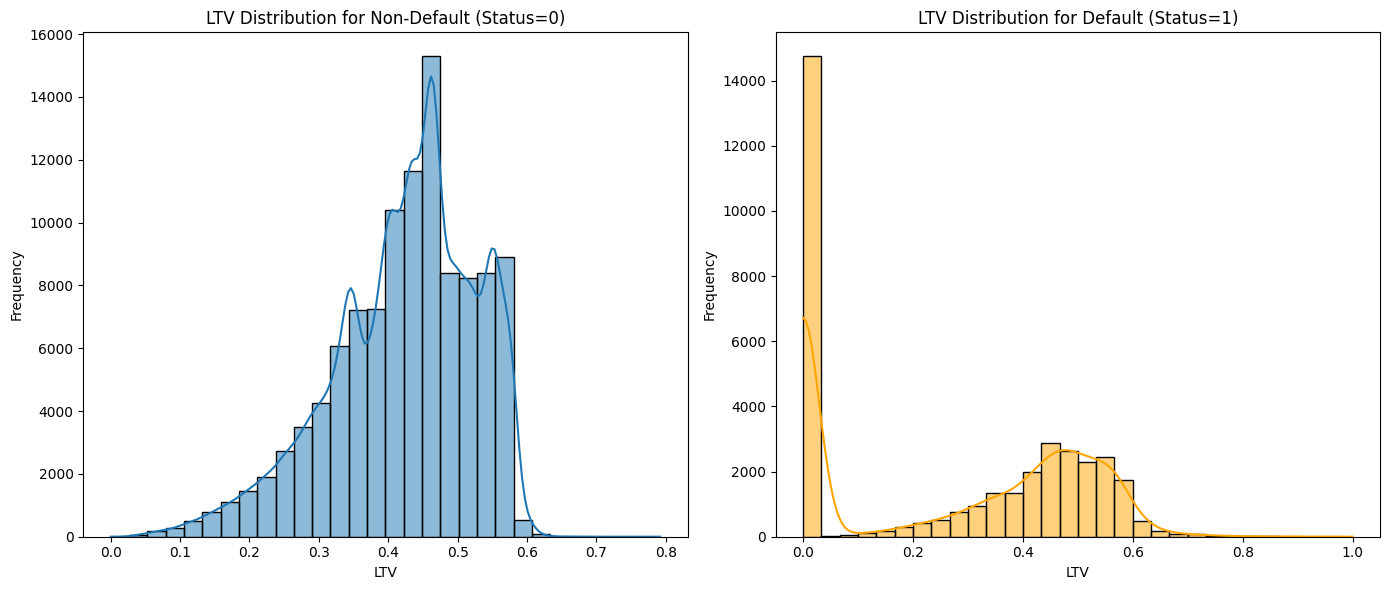

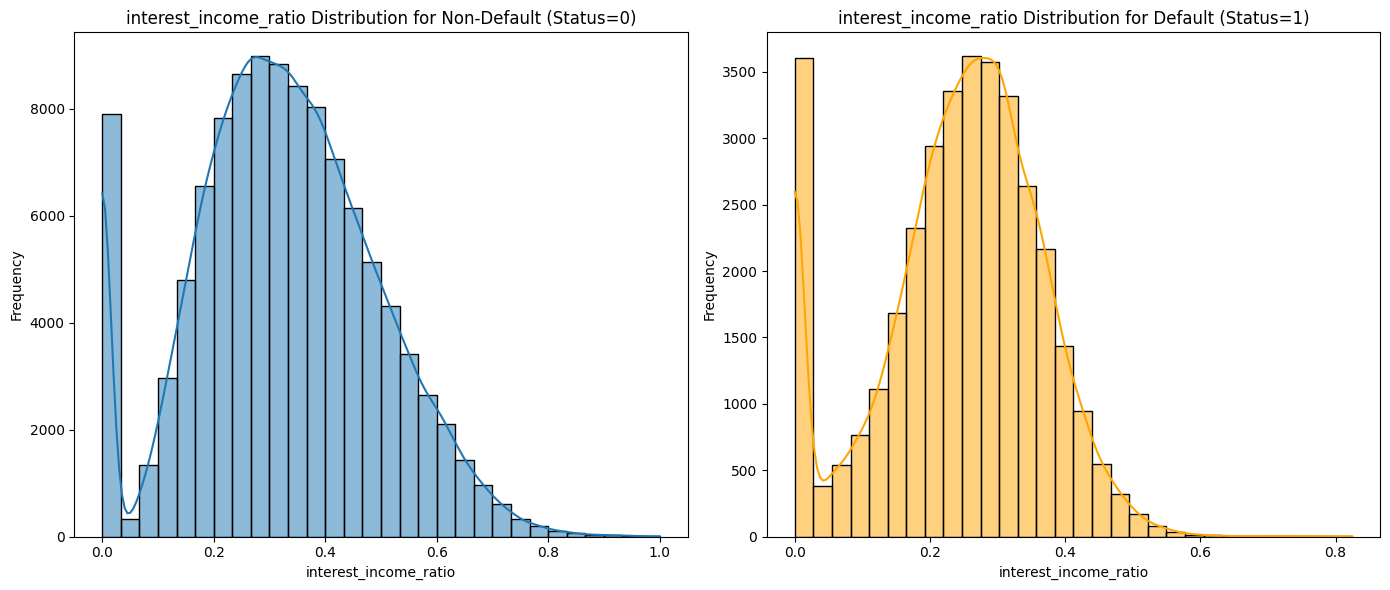

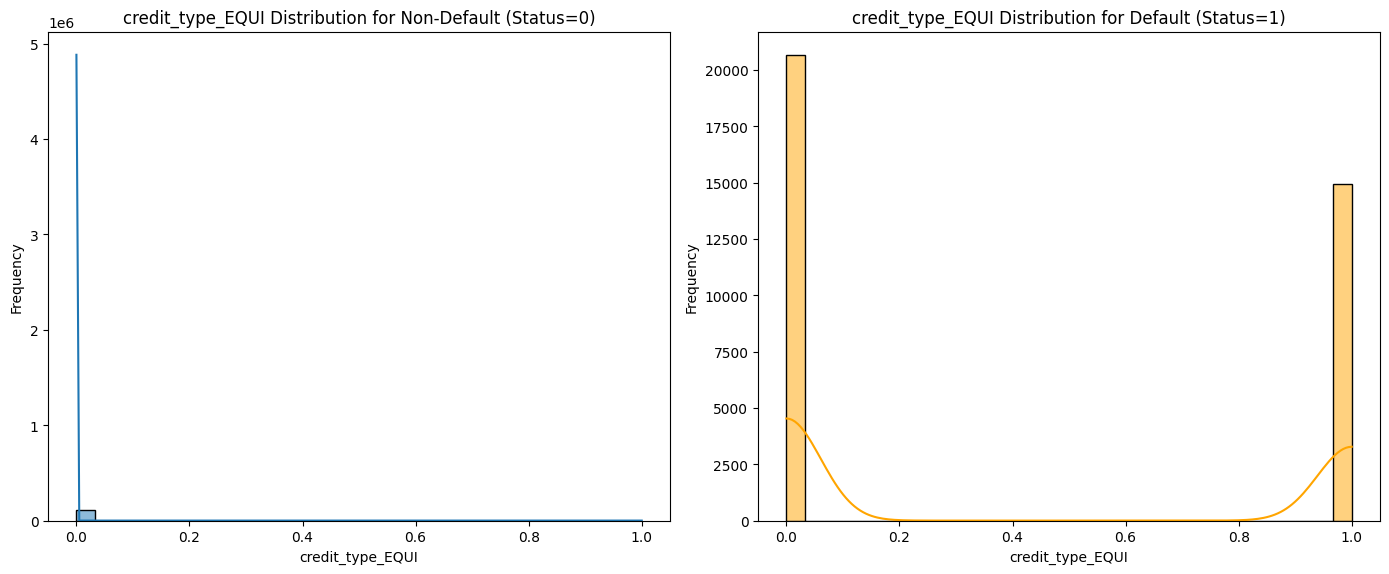

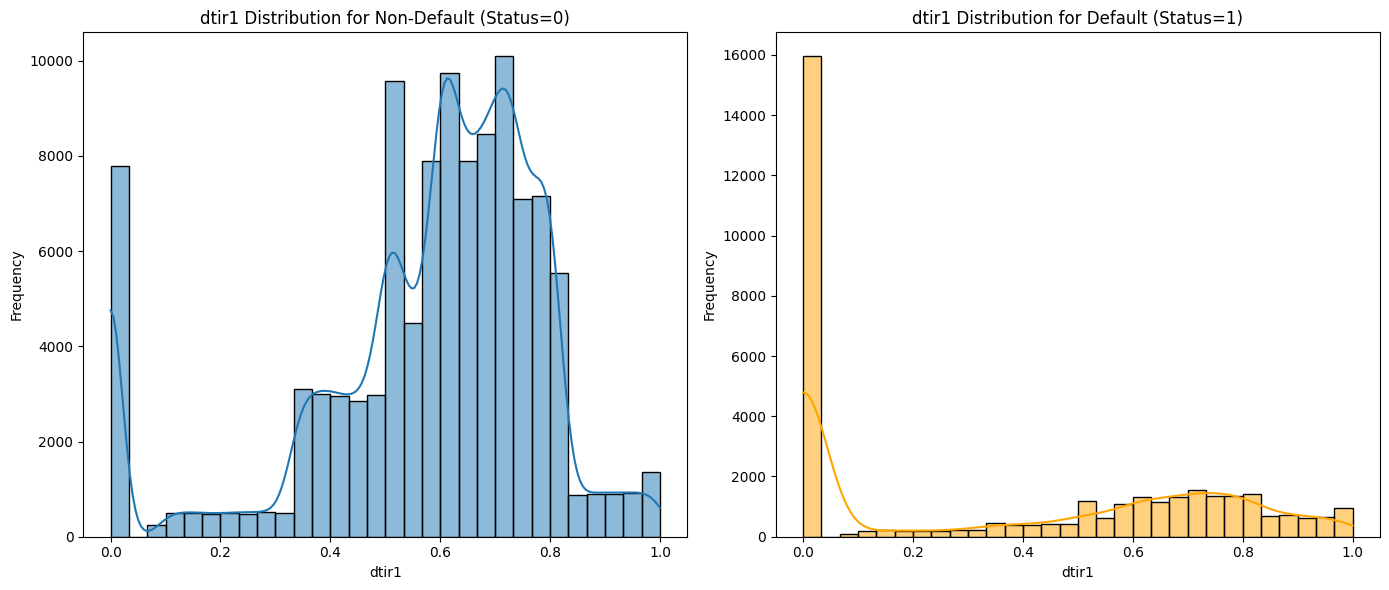

In [19]:
# List of variables to investigate
#variables_to_check = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges']
variables_to_check = ['rate_of_interest', 'LTV', 'interest_income_ratio', 'credit_type_EQUI', 'dtir1']

# Separate data by Status (Default = 1 and Non-Default = 0)
default_data = data_processed[data_processed['Status'] == 1]
non_default_data = data_processed[data_processed['Status'] == 0]

# Plot distributions for each variable by Status
for var in variables_to_check:
    plt.figure(figsize=(14, 6))

    # Distribution for Non-Default Status (0)
    plt.subplot(1, 2, 1)
    sns.histplot(non_default_data[var], kde=True, bins=30)
    plt.title(f'{var} Distribution for Non-Default (Status=0)')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    # Distribution for Default Status (1)
    plt.subplot(1, 2, 2)
    sns.histplot(default_data[var], kde=True, bins=30, color='orange')
    plt.title(f'{var} Distribution for Default (Status=1)')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# 6. Prepare the Data for Modeling

In [20]:
# Define target variable and features
target_column = 'Status'
X = data_processed.drop(columns=[target_column])
y = data_processed[target_column]

In [21]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Check target distribution
print("Training set target distribution:")
print(y_train.value_counts())

print("Test set target distribution:")
print(y_test.value_counts())

Training set target distribution:
Status
0.0    87334
1.0    28512
Name: count, dtype: int64
Test set target distribution:
Status
0.0    21856
1.0     7106
Name: count, dtype: int64


Distribution of Status:
Status
0.0    75.403293
1.0    24.596707
Name: proportion, dtype: float64

Summary statistics by Status (mean):
        loan_amount  rate_of_interest  property_value    income  Credit_Score  \
Status                                                                          
0.0        0.273601          0.465256        0.280786  0.273449       0.49889   
1.0        0.252593          0.465316        0.253410  0.237839       0.50161   

             LTV     dtir1  interest_income_ratio  LTV_missing  dtir1_missing  \
Status                                                                          
0.0     0.422699  0.577964               0.324016     0.000018       0.071279   
1.0     0.262474  0.363604               0.242216     0.414004       0.447892   

        ...  age_missing  submission_of_application_missing  \
Status  ...                                                   
0.0     ...     0.000000                           0.000000   
1.0     ...     0.005587 

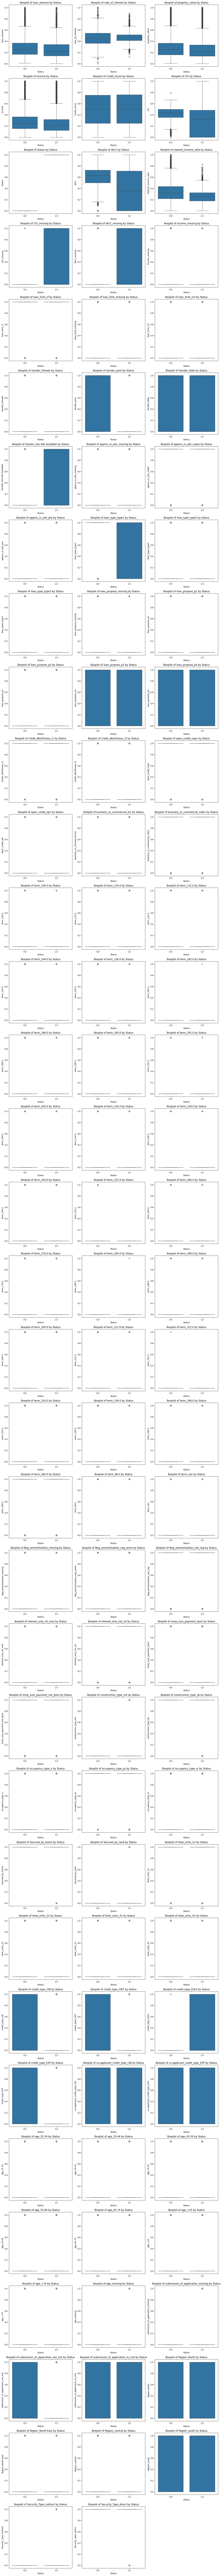

<Figure size 1500x0 with 0 Axes>

In [ ]:
# 1. Distribution of the target variable `Status`
print("Distribution of Status:")
print(data_processed['Status'].value_counts(normalize=True) * 100)

# 2. Summary statistics for numerical variables by `Status`
print("\nSummary statistics by Status (mean):")
print(data_processed.groupby('Status').mean())

# 3. Additional statistical measures like median and standard deviation
print("\nMedian by Status:")
print(data_processed.groupby('Status').median())
print("\nStandard deviation by Status:")
print(data_processed.groupby('Status').std())

# 4. Visualization: Boxplots for numerical variables
numeric_columns = data_processed.select_dtypes(include=['float64', 'int64']).columns
num_numeric_columns = len(numeric_columns)
num_rows = math.ceil(num_numeric_columns / 3)

plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, 3, i)
    sns.boxplot(x='Status', y=col, data=data_processed)  # Use data_processed here
    plt.title(f'Boxplot of {col} by Status')
plt.tight_layout()
plt.show()

# 5. Visualization: Countplots for categorical variables
categorical_columns = data_processed.select_dtypes(include=['object']).columns
num_categorical_columns = len(categorical_columns)
num_rows = math.ceil(num_categorical_columns / 3)

plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, 3, i)
    sns.countplot(x=col, hue='Status', data=data_processed)
    plt.title(f'Countplot of {col} by Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Model Selection and Initial Tests

**Why is Recall particularly important?**


In loan default prediction, the goal is to identify loans that might default (class `1`) so that actions can be taken, such as conducting additional checks or setting stricter requirements for these applicants. Recall for the default class (class `1`) is crucial here because:
1. Recall measures the model's ability to detect actual defaults: A high recall value means the model is capturing a large portion of true defaults, reducing the risk of "false negatives" (loans that default but are predicted as safe).
2. Minimizing costs and risks: False negatives can be costly for a bank or lending institution, as undetected defaults could lead to significant financial losses. Recall helps mitigate this risk.

**How does Recall differ from Precision?**


1. Recall: Measures the proportion of actual defaults that were correctly identified by the model. It answers the question: How many of the true defaults did the model detect?
2. Precision: Measures the proportion of predicted defaults that are actual defaults. It answers: How reliable are the default predictions?
While Precision is also valuable, in this case, it's often more desirable to have a model that over-identifies defaults rather than misses them (higher Recall).

**Models that are suitable for high Recall**
1. Random Forest
2. Gradient Boosting 
3. Logistic Regression
4. Support Vector Machines
5. Naive Bayes

Checking the target distribution helps us to make an informed decision about the balancing strategy and to ensure that our model is trained and tested fairly. Depending on the distribution, we then decide whether a simple balancing or a stronger adjustment (e.g. SMOTE) is necessary.

In [24]:
# Create data backup
data_processed_backup = data_processed.copy()

In [25]:
data = data_processed

In [27]:
# Define target variable and features
target_column = 'Status'  # Target column for loan default prediction
X = data.drop(columns=[target_column])
y = data[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check target distribution in the full dataset, training set, and test set
print("Full dataset target distribution:")
print(y.value_counts(normalize=True) * 100)

print("\nTraining set target distribution:")
print(y_train.value_counts(normalize=True) * 100)

print("\nTest set target distribution:")
print(y_test.value_counts(normalize=True) * 100)

Full dataset target distribution:
Status
0.0    75.403293
1.0    24.596707
Name: proportion, dtype: float64

Training set target distribution:
Status
0.0    75.388015
1.0    24.611985
Name: proportion, dtype: float64

Test set target distribution:
Status
0.0    75.464402
1.0    24.535598
Name: proportion, dtype: float64


To start with, use class_weight='balanced' in the models. This is a straightforward approach and should be sufficient for this type of distribution. 

# 8. Create Baseline Model

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Function to evaluate model using Cross-Validation with fewer folds
def evaluate_model_cv(model, X, y, cv=3):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

# Dictionary to store results
results_cv = {}

# Evaluate each model using Cross-Validation
for model_name, model in models.items():
    print(f"Evaluating {model_name} with Cross-Validation...")
    metrics_cv = evaluate_model_cv(model, X_train, y_train, cv=3)
    results_cv[model_name] = metrics_cv
    print(f"{model_name} Cross-Validation Metrics: {metrics_cv}\n")

# Display Cross-Validation results in a DataFrame
results_cv_df = pd.DataFrame(results_cv).T
print("Cross-Validated Model Performance:")
print(results_cv_df)


Evaluating Random Forest with Cross-Validation...
Random Forest Cross-Validation Metrics: {'Accuracy': np.float64(0.926652603491394), 'Precision': np.float64(0.9736237901563776), 'Recall': np.float64(0.7215558361391695), 'F1 Score': np.float64(0.8288108316888544)}

Evaluating Gradient Boosting with Cross-Validation...
Gradient Boosting Cross-Validation Metrics: {'Accuracy': np.float64(0.9660670297655164), 'Precision': np.float64(0.9927829345840187), 'Recall': np.float64(0.8684413580246915), 'F1 Score': np.float64(0.9264529996294039)}

Evaluating Logistic Regression with Cross-Validation...
Logistic Regression Cross-Validation Metrics: {'Accuracy': np.float64(0.88106624384327), 'Precision': np.float64(0.7402961620623442), 'Recall': np.float64(0.7960157126823794), 'F1 Score': np.float64(0.7671455066840562)}

Evaluating Naive Bayes with Cross-Validation...
Naive Bayes Cross-Validation Metrics: {'Accuracy': np.float64(0.858691699168725), 'Precision': np.float64(0.9227650828964064), 'Recall

# 9. Model Comparison

# 10. Model Optimization (hyperparameter tuning)

In [30]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Set up GridSearchCV for Gradient Boosting with class balancing and a focus on maximizing recall
grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='recall',  # Optimize for recall
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV on the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Retrieve the best model and its parameters
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best Recall:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best Recall: 0.9783600267490764


# 11. Model Selection and Evaluation

In [34]:
from sklearn.metrics import classification_report, precision_recall_curve

# Retrieve prediction probabilities for the positive class (1)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Set a custom threshold for classifying as positive
threshold = 0.3
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# Calculate metrics for the adjusted predictions
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     21856
         1.0       0.99      0.98      0.99      7106

    accuracy                           0.99     28962
   macro avg       0.99      0.99      0.99     28962
weighted avg       0.99      0.99      0.99     28962



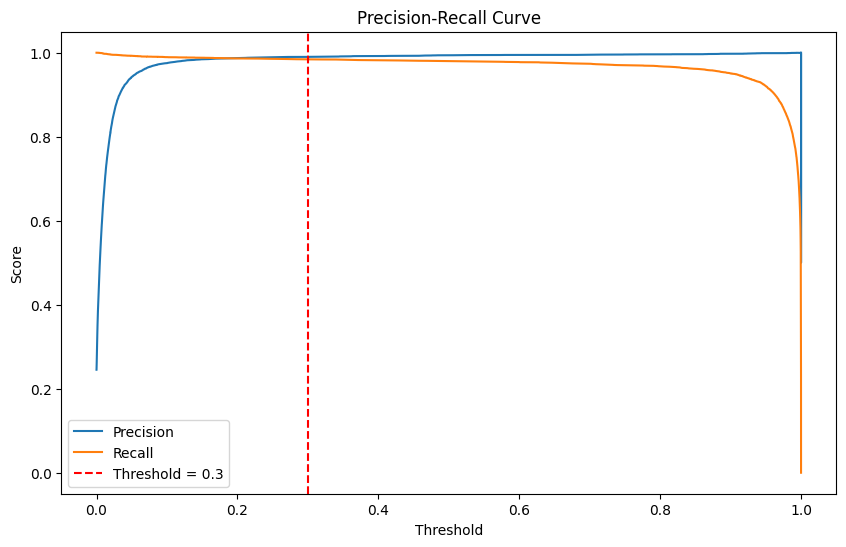

In [35]:
# Evaluate Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.axvline(threshold, color='r', linestyle='--', label=f"Threshold = {threshold}")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [44]:
# Misclassified examples
misclassified = X_test[(y_test != y_pred_adjusted)]
print(f"Number of misclassified examples: {len(misclassified)}")

# Analyze false negatives
false_negatives = X_test[(y_test == 1) & (y_pred_adjusted == 0)]
print(f"Number of false negatives: {len(false_negatives)}")

Number of misclassified examples: 182
Number of false negatives: 112


In [ ]:
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Top Features:")
print(feature_importance_df.head(10))
print("Worst Features:")
print(feature_importance_df.tail(10))

Top Features:
                      Feature  Importance
82           credit_type_EQUI    0.379344
1            rate_of_interest    0.343624
7       interest_income_ratio    0.068394
6                       dtir1    0.052886
5                         LTV    0.049808
3                      income    0.033213
0                 loan_amount    0.017763
67      lump_sum_payment_lpsm    0.011205
8                 LTV_missing    0.007744
64  Neg_ammortization_not_neg    0.007732
Worst Features:
                 Feature  Importance
70  construction_type_sb         0.0
51            term_280.0         0.0
40            term_165.0         0.0
61              term_nan         0.0
55            term_322.0         0.0
44            term_204.0         0.0
46            term_228.0         0.0
48            term_252.0         0.0
52            term_288.0         0.0
74       Secured_by_home         0.0


# 12. Saving the Best Model

In [40]:
import joblib

# Define the main project directory
ROOT_PATH = pathlib.Path.cwd().parents[0]
model_path = ROOT_PATH / 'models' / 'best_model.pkl'

# Save the model
joblib.dump(best_model, model_path)
print(f"Model saved successfully at {model_path}")

Model saved successfully at /Users/giliamo/code/YannAll/automated_loan_review_project/models/best_model.pkl


In [41]:
# Define the path for saving the processed data
processed_data_path = ROOT_PATH / 'raw_data' / 'loan_preprocessed_v2.csv'

# Save the processed DataFrame as CSV
data_processed.to_csv(processed_data_path, index=False)
print(f"Processed data saved successfully at {processed_data_path}")

Processed data saved successfully at /Users/giliamo/code/YannAll/automated_loan_review_project/raw_data/loan_preprocessed_v2.csv
